In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

from window_data import *

import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Get Data

In [2]:
breath_df = pd.read_pickle('breath_pickle')
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]

In [3]:
# Use subset of data for now
under2 = under2[0:500]

## Create Windowed Data

In [4]:
num_outputs=50

In [5]:
df = create_sliding_window_data(n_steps=500, num_outputs=num_outputs, dataset=under2['Trace'])

In [6]:
df.head()

,Trace,Next_pts,Trace_num
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[-0.0172, -0.0185, -0.0198, -0.0211, -0.0224, ...",0
1,"[0.0522, 0.056, 0.0598, 0.0638, 0.0678, 0.0718...","[-0.0445, -0.0449, -0.0453, -0.0457, -0.0461, ...",0
2,"[0.3095, 0.3149, 0.3203, 0.3257, 0.331, 0.3362...","[-0.0129, -0.0113, -0.0096, -0.0077, -0.0057, ...",0
3,"[0.5461, 0.55, 0.5538, 0.5575, 0.5612, 0.5649,...","[0.1655, 0.17, 0.1746, 0.1792, 0.1839, 0.1886,...",0
4,"[0.7072, 0.7096, 0.7119, 0.714, 0.716, 0.7177,...","[0.4106, 0.4155, 0.4204, 0.4254, 0.4304, 0.435...",0


## Train Val Test Split

In [7]:
df['Trace_num'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [8]:
train = df[df['Trace_num']>=51]
valid = df[(df['Trace_num']>=40) & (df['Trace_num']<51)]
test = df[df['Trace_num']<40]

In [9]:
X_train = train['Trace']
y_train = train['Next_pts']

X_val = valid['Trace']
y_val = valid['Next_pts']

X_test = test['Trace']
y_test = test['Next_pts']

## Scale Data

In [10]:
scaler = StandardScaler()
# Fit
scaler.fit(list(X_train))
# Transform
x_train = scaler.transform(list(X_train))
x_val = scaler.transform(list(X_val))
x_test = scaler.transform(list(X_test))

In [11]:
print(x_train.shape, x_val.shape, x_test.shape)

(50613, 500) (1533, 500) (4324, 500)


##  Reshape Data

In [12]:
def reshape_trace(trace):
    trace = np.transpose(trace)
    return trace.reshape(trace.shape[0],trace.shape[1], 1)

In [13]:
x_train = reshape_trace(x_train)
x_val = reshape_trace(x_val)
x_test = reshape_trace(x_test)

In [14]:
print(x_train.shape, x_val.shape, x_test.shape)

(500, 50613, 1) (500, 1533, 1) (500, 4324, 1)


In [15]:
y_train2 = reshape_trace(list(y_train))
y_val2 = reshape_trace(list(y_val))
y_test2 = reshape_trace(list(y_test))

## Define Dataset

In [16]:
#dataset
from torch.utils.data import Dataset

In [17]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [18]:
dataset = timeseries(x_train,y_train2)
test_dataset = timeseries(x_val,y_val2)
final_test_dataset = timeseries(x_test,y_val2)

In [19]:
dataset.x.shape

torch.Size([500, 50613, 1])

In [20]:
train_loader = DataLoader(dataset,shuffle=False,batch_size=200)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=200)

## Define LSTM Encoder and Decoder (Multistep Prediction)

In [21]:
# neural network
from torch import nn

class lstm_encoder(nn.Module):
    ''' Encodes a time series sequence '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_encoder, self).__init__()
        self.input_size = input_size # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers # number of recurrent layers 
        
        # define an LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        
    def forward(self, x):
        output, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], self.input_size))
        
        return output, self.hidden   # hidden gives the hidden state and cell state for the last element in the sequence 
                                     # give this to decoder
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
        

In [22]:
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_decoder, self).__init__()
        self.input_size = input_size   # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers   # number of recurrent layers

        # Define LSTM layer and Linear layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)       
    
    
    def forward(self, x, encoder_hidden_states):
        output, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden_states)
        output = self.linear(output.squeeze(0))     
        
        return output, self.hidden


## Define Model

In [23]:
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size=1, hidden_size=5):

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size   # number of expected features in the input X
        self.hidden_size = hidden_size # number of features in the hidden state h
        
        # Encoder and decoder
        self.encoder = lstm_encoder(input_size=input_size, hidden_size=hidden_size)
        self.decoder = lstm_decoder(input_size=input_size, hidden_size=hidden_size)
        
    
    def train_model(self, input_tensor, target_tensor, n_epochs, target_len,batch_size,learning_rate = 0.01):
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iteraations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                batch_loss = 0.
  
                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = decoder_output
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))

        return losses

        
    def predict(self, input_tensor, target_len):
        
        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


## Train a model

In [24]:
mymodel = lstm_seq2seq(input_size=1, hidden_size=5)
print(f'Model Details - Hidden Size {5} \t Learning Rate: {0.001}')
train_loss = mymodel.train_model(dataset.x, dataset.y, n_epochs = 30, target_len = num_outputs, batch_size = 200, learning_rate = 0.001)
modname = 'lstm_encode_decode_' + '50_sliding'
torch.save(mymodel, modname)

Model Details - Hidden Size 5 	 Learning Rate: 0.001


100%|██████████| 30/30 [10:30<00:00, 21.03s/it, loss=0.003]


In [39]:
mod = lstm_seq2seq(input_size=1, hidden_size=5)
mod = torch.load('lstm_encode_decode_50_sliding')

## Plots

In [26]:
test_preds = gather_preds(mod, final_test_dataset, num_outputs)
valid_preds = gather_preds(mod, test_dataset, num_outputs)
train_preds = gather_preds(mod, dataset, num_outputs)

In [27]:
train['preds'] = train_preds
valid['preds'] = valid_preds
test['preds'] = test_preds

<ipython-input-27-9221ef3f2022>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['preds'] = train_preds
<ipython-input-27-9221ef3f2022>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['preds'] = valid_preds
<ipython-input-27-9221ef3f2022>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [28]:
train.to_pickle("train_df_50_sliding.pkl")  
valid.to_pickle("valid_df_50_sliding.pkl")  
test.to_pickle("test_df_50_sliding.pkl")  

In [29]:
train = pd.read_pickle("train_df_50_sliding.pkl") 
valid = pd.read_pickle("valid_df_50_sliding.pkl")  
test = pd.read_pickle("test_df_50_sliding.pkl")  

In [30]:
train.head()

,Trace,Next_pts,Trace_num,preds
5857,"[0.0002, 0.0006, 0.001, 0.0017, 0.0025, 0.0037...","[0.0999, 0.0954, 0.0912, 0.0873, 0.0837, 0.080...",51,"[0.1687715, 0.14178571, 0.108114004, 0.0938361..."
5858,"[0.2925, 0.3013, 0.3101, 0.319, 0.3279, 0.3369...","[0.2118, 0.2219, 0.2322, 0.2425, 0.253, 0.2634...",51,"[0.27335656, 0.25979257, 0.2436879, 0.24561165..."
5859,"[0.7513, 0.7615, 0.7716, 0.7817, 0.7917, 0.801...","[0.7437, 0.7546, 0.7654, 0.7762, 0.787, 0.7978...",51,"[0.7513958, 0.75437045, 0.7499374, 0.7553689, ..."
5860,"[1.2132, 1.2214, 1.2295, 1.2374, 1.2452, 1.252...","[1.2621, 1.2732, 1.2843, 1.2954, 1.3067, 1.318...",51,"[1.2545328, 1.2879362, 1.2996664, 1.3115981, 1..."
5861,"[1.6083, 1.6162, 1.624, 1.6319, 1.6399, 1.6478...","[1.7499, 1.7576, 1.7652, 1.7726, 1.7798, 1.786...",51,"[1.7300844, 1.781947, 1.7969139, 1.8061705, 1...."


In [31]:
train_full_traces = train.groupby('Trace_num')['Next_pts'].apply(list)
valid_full_traces = valid.groupby('Trace_num')['Next_pts'].apply(list)
test_full_traces = test.groupby('Trace_num')['Next_pts'].apply(list)

In [32]:
train_pred_trace = train.groupby('Trace_num')['preds'].apply(list)
valid_pred_trace = valid.groupby('Trace_num')['preds'].apply(list)
test_pred_trace = test.groupby('Trace_num')['preds'].apply(list)

In [33]:
test.head(3)

,Trace,Next_pts,Trace_num,preds
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[-0.0172, -0.0185, -0.0198, -0.0211, -0.0224, ...",0,"[0.079119116, 0.05768305, 0.025768906, 0.01305..."
1,"[0.0522, 0.056, 0.0598, 0.0638, 0.0678, 0.0718...","[-0.0445, -0.0449, -0.0453, -0.0457, -0.0461, ...",0,"[0.05906698, 0.039102525, 0.007642269, -0.0046..."
2,"[0.3095, 0.3149, 0.3203, 0.3257, 0.331, 0.3362...","[-0.0129, -0.0113, -0.0096, -0.0077, -0.0057, ...",0,"[0.08509025, 0.066105574, 0.037240595, 0.02733..."


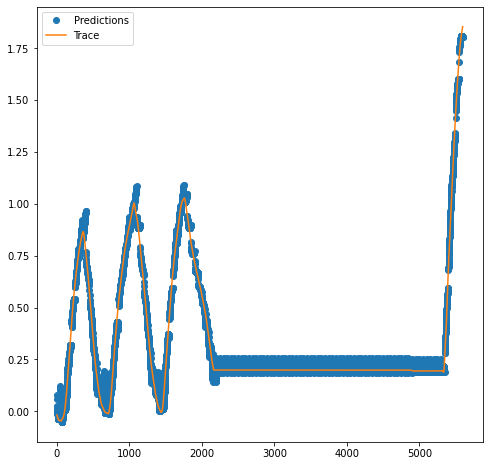

In [34]:
fig, ax = plt.subplots(figsize=(8,8))
trace = np.concatenate(test_pred_trace[0]).ravel().tolist()
plt.plot(trace, 'o', label='Predictions')

trace = np.concatenate(test_full_traces[0]).ravel().tolist()
plt.plot(trace, '-', label='Trace')

plt.legend(loc='best')
plt.show()

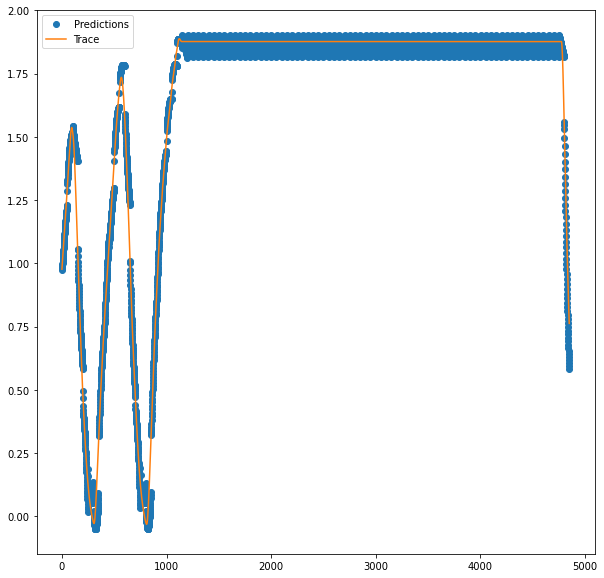

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
trace = np.concatenate(test_pred_trace[19]).ravel().tolist()
plt.plot(trace, 'o', label='Predictions')

trace = np.concatenate(test_full_traces[19]).ravel().tolist()
plt.plot(trace, '-', label='Trace')

plt.legend(loc='best')
plt.show()

In [36]:
# error in first 10 pts 

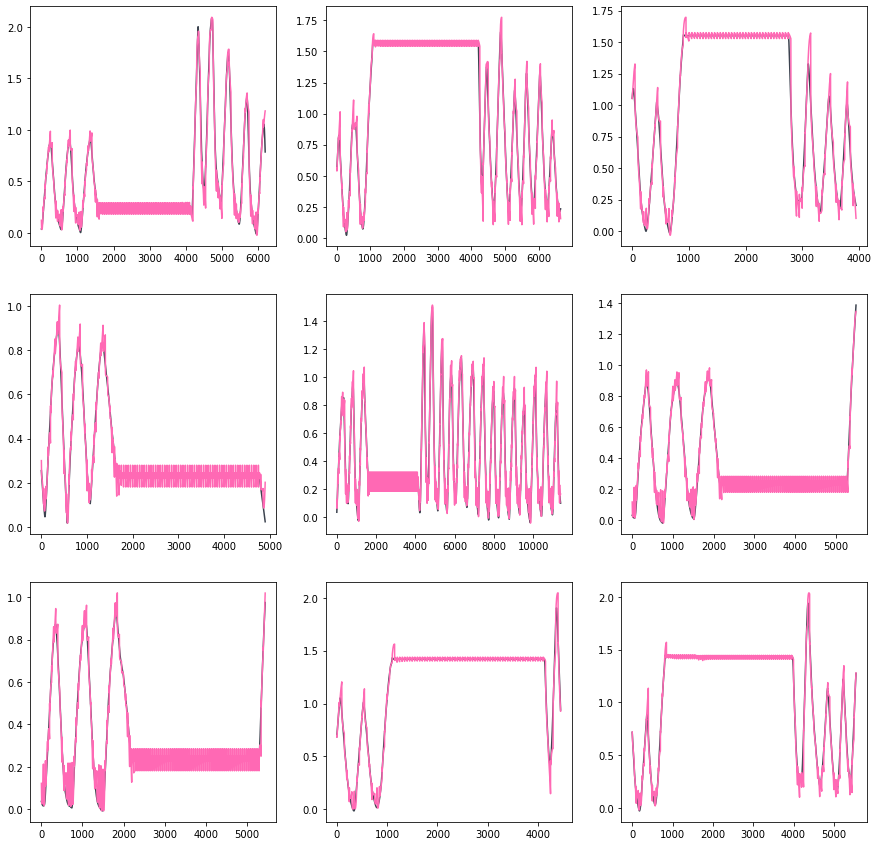

In [37]:
reconstruct_trace(test_full_traces, test_pred_trace)

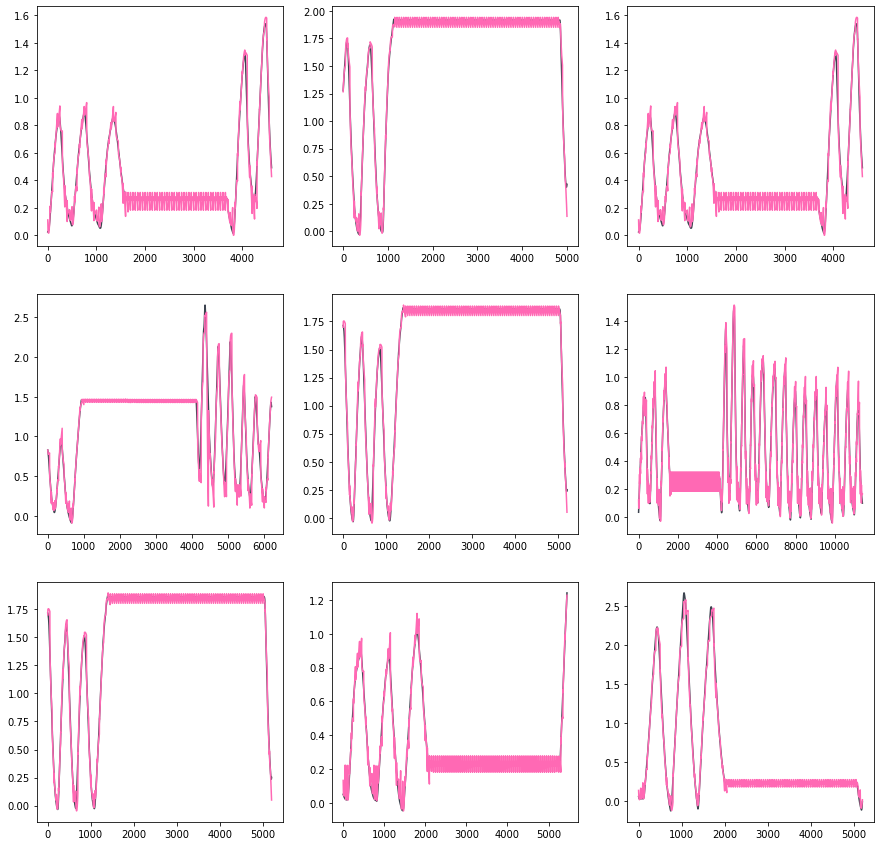

In [38]:
reconstruct_trace(test_full_traces, test_pred_trace)

In [40]:
from collections import defaultdict

In [45]:
errors = defaultdict(list)
for i in range(len(test_pred_trace)):
    for j in range(len(test_pred_trace[i])):
        for k in range(50):
            error = (test_full_traces[i][j][k] - test_pred_trace[i][j][k])**2
            errors[k].append(error)
mse =  defaultdict(int)
for i in range(50):
    mse[i] = np.sqrt(np.mean(errors[i]))

[]

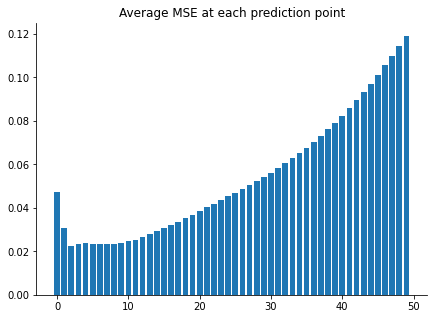

In [46]:
fig, ax = plt.subplots( figsize=(7,5))
ax.bar(mse.keys(), mse.values())
ax.set_title("Average MSE at each prediction point")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot()

In [47]:
errors = []
y = np.concatenate(test_full_traces[19]).ravel().tolist()
pred = np.concatenate(test_pred_trace[19]).ravel().tolist()
for i in range(len(y)):
    error = (y[i]-pred[i])**2
    errors.append(error)

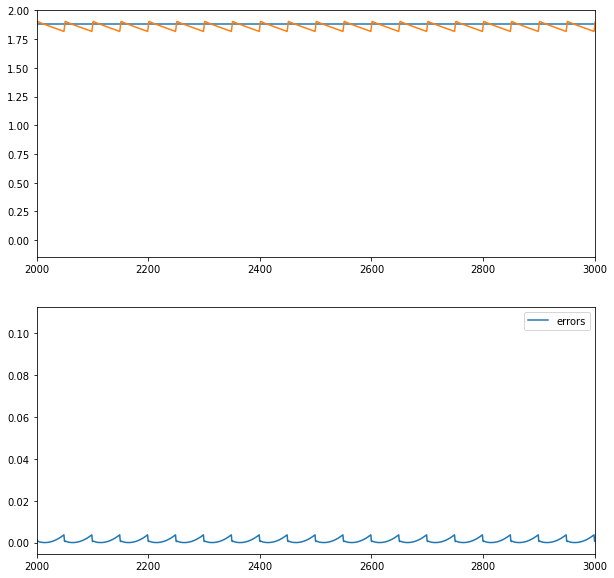

In [51]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

trace = np.concatenate(test_full_traces[19]).ravel().tolist()
ax[0].plot(trace, '-', label='Trace')
trace = np.concatenate(test_pred_trace[19]).ravel().tolist()
ax[0].plot(trace, '-', label='Predictions')
ax[0].set_xlim(2000,3000)

ax[1].plot(errors, '-', label='errors')
ax[1].set_xlim(2000,3000)

plt.legend(loc='best')
plt.show()

In [ ]:
# review hui's paper
# change sampling rate- effect of sampling rate